In [32]:
!pip install konlpy
from konlpy.tag import Komoran, Okt
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data

In [33]:
%matplotlib inline
device = 'cuda' if torch.cuda.is_available() else 'cpu'
torch.manual_seed(515)

In [34]:
print(device)

cuda


In [35]:
!git clone https://github.com/choi-hyunkyu/data.git
#tokenizer = Komoran()
tokenizer = Okt()
original_data_df = pd.read_csv('./data/data/movie_rating_data.csv')

fatal: destination path 'data' already exists and is not an empty directory.


In [36]:
original_data_df.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [37]:
original_data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   id        200000 non-null  int64 
 1   document  199992 non-null  object
 2   label     200000 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 4.6+ MB


In [38]:
input_data = original_data_df.drop(['id'], axis = 1).astype('str')[:20000]

In [39]:
input_data.head()

,document,label
0,아 더빙.. 진짜 짜증나네요 목소리,0
1,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,너무재밓었다그래서보는것을추천한다,0
3,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [40]:
input_data.shape

(20000, 2)

In [41]:
# preprocessing
def visualizing_length(text):
    max_len = max(len(l) for l in text)
    min_len = min(len(l) for l in text)
    avg_len = (sum(map(len, text))/len(text))
    print('최대 길이 : %d' % max_len)
    print('최소 길이 : %d' % min_len)
    print('평균 길이 : %f' % avg_len)
    plt.hist([len(s) for s in text], bins=50)
    plt.xlabel('length of sample')
    plt.ylabel('number of sample')
    plt.show()
    return max_len, min_len, avg_len

def vocab(text_df):
    out_df = length_normalizing(text_df)
    out_df = normalizeString_df(out_df)
    out_df = strip_df(out_df)
    out_df = empty2nan(out_df)
    out_df = deleteNan(out_df)
    out_df = shuffle_df(out_df)
    label_list = out_df[out_df.keys()[1]].tolist()
    text_list = out_df[out_df.keys()[0]].tolist()
    token = tokenizing(text_list)
    output = uniquewords(token)
    words = word2index(output)
    words['<PAD>'] = 0
    words['<OOV>'] = 1
    return token, words, len(words), label_list

def word2index(unique_word_list):
    return {value: index+2 for index, value in enumerate(unique_word_list)}

def uniquewords(word_list):
    return list(set([i for value in word_list for i in value]))

def tokenizing(text_list):
    return [tokenizer.morphs(sentence, stem=True) for sentence in text_list]

def shuffle_df(text_df):
    return text_df.sample(frac=1).reset_index(drop=True)

def deleteNan(text_df):
    text_df = text_df.dropna(how = 'any').reset_index(drop=True)
    return text_df

def empty2nan(text_df):
    text_df[text_df.keys()[0]] = text_df[text_df.keys()[0]].replace('', np.nan)
    return text_df

def strip_df(text_df):
    sub_list = [text.strip() for text in text_df[text_df.keys()[0]]]
    text_df[text_df.keys()[0]] = sub_list
    return text_df.reset_index(drop=True)

def normalizeString_df(text_df):
    text_list = [normalizeString(sentence) for sentence in text_df[text_df.keys()[0]]]
    input_df = pd.DataFrame({text_df.keys()[0]: text_list})
    label_df = text_df.drop(text_df.keys()[0], axis = 1)
    fixed_df = pd.concat([input_df, label_df], axis = 1)
    return fixed_df

def normalizeString(s):
    hangul = re.compile('[^ ㄱ-ㅣ가-힣 ^☆.!?]+')
    result = hangul.sub('', s)
    result = re.sub('[-=+,#/\?:^$.@*\"※~&%ㆍ!』\\‘|\(\)\[\]\<\>`\'…》]', '', result)
    return result

def length_normalizing(text_df):
    for i, v in enumerate(text_df[text_df.keys()[0]]):
        if len(text_df[text_df.keys()[0]][i]) > 25 or len(text_df[text_df.keys()[0]][i]) < 10:
            text_df.drop(index=[i], inplace=True)
    return text_df.reset_index(drop=True)

In [42]:
# utils
def train(model, criterion, optimizer, nb_epochs, 
          input_size, train_dataloader, validation_dataloader):
    
    # Train loop
    trn_loss_list = []
    val_loss_list = []
    for epoch in range(nb_epochs):

        # Train
        trn_loss = 0.0
        for trn_batch, train_samples in enumerate(train_dataloader):

            # train data setting
            x_train, y_train = train_samples
            x_train = x_train.unsqueeze(0).to(device)
            y_train = y_train.view(-1).long().to(device)

            # train
            model.train()
            hypothesis = model(x_train).view(-1, hidden_size)
            optimizer.zero_grad()
            train_loss = criterion(hypothesis, y_train)
            train_loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), max_norm)
            optimizer.step()

            # train loss
            trn_loss += train_loss.item() / len(train_dataloader)
        trn_loss_list.append(trn_loss)

        # Evaluation
        with torch.no_grad():
            val_loss = 0.0
            for val_batch, validation_samples in enumerate(validation_dataloader):

                # validatoin data setting
                x_validation, y_validation = validation_samples
                x_validation = x_validation.unsqueeze(0).to(device)
                y_validation = y_validation.view(-1).long().to(device)

                # evaluation
                model.eval()
                prediction = model(x_validation).view(-1, hidden_size)
                validation_loss = criterion(prediction, y_validation)

                # validation loss
                val_loss += validation_loss.item() / len(validation_dataloader)
            val_loss_list.append(val_loss)

        print("Epoch: {:3d} | Train Loss: {:.6f} | Val Loss: {:.6f}".format(epoch + 1, trn_loss, val_loss))
    #torch.save(model, './data/temperature_model.pt')
    return trn_loss_list, val_loss_list

def checkdata(dataloader):
    for index, value in enumerate(dataloader):
        while index < 6:
            x, y = value
            print("{} Batch".format(index))
            print("Input: {}".format(x.shape))
            print("Target: {}".format(y.shape))
            break

def checkfunction(dataloader, epoch):
    for batch, value in enumerate(dataloader):
      x_, y_ = value
      print(batch)
      x_ = x_.unsqueeze(0).to(device)
      print(x_.size())
      hypothesis = model(x_).view(-1, hidden_size)
      print(hypothesis.size())
      y_ = y_.view(-1).long().to(device)
      print(y_.size())
      loss = criterion(hypothesis, y_)
      print(loss)
      print()
      if batch == epoch:
        break

def SplitData(encoded_ip, label):
    total_size = len(encoded_ip)

    train_input_data = encoded_ip[0:int(total_size * 0.7)]
    train_target_data = label[0:int(total_size * 0.7)]

    validation_input_data = encoded_ip[int(total_size * 0.7):]
    validation_target_data = label[int(total_size * 0.7):]
    
    return (train_input_data, 
            train_target_data, 
            validation_input_data, 
            validation_target_data)

def MakeDataset(input_data, target_data):
    dataset_size = len(input_data)
    input_ts = torch.FloatTensor(np.array(input_data))
    target_ts = torch.FloatTensor(np.array(target_data).astype('float64')).view(-1, 1)
    dataset = data.TensorDataset(input_ts, target_ts)
    return dataset, dataset_size

def MakeDataLoader(dataset, batch_size):
    return data.DataLoader(dataset, batch_size = batch_size, shuffle = True, drop_last = True)

def integerEncoding(tokenized_data, vocab):
    encoded = []
    for line in tokenized_data:
        temp = []
        for w in line:
            try:
                temp.append(vocab[w])
            except KeyError:
                temp.append(vocab['<OOV>'])
        encoded.append(temp)
    return encoded
    
def padding(encoded, vocab, max_length):
    for line in encoded:
        if len(line) < max_length:
            line += [vocab['<PAD>']] * (max_length - len(line))

In [43]:
# model
class BILSTM(nn.Module):
    def __init__(self, input_size, batch_size, hidden_size, num_layers, vocab_size, embedding_dim, dropout_p = 0.2):
        super(BILSTM, self).__init__()
        
        self.input_size = input_size
        self.batch_size = batch_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        
        self.embedding = nn.Embedding(self.vocab_size, self.embedding_dim)
        self.lstm = nn.LSTM(
            input_size = self.input_size,
            hidden_size = self.hidden_size,
            num_layers = self.num_layers,
            dropout = 0.3,
            #batch_first = True,
            bidirectional = True)
        self.fc = nn.Linear(
            in_features = self.hidden_size * 2, 
            out_features = self.hidden_size, 
            bias = True)
        nn.init.xavier_uniform_(self.fc.weight)
        
    def forward(self, x):
        # init hidden and cell state
        h_0 = torch.zeros(self.num_layers * 2, self.batch_size, self.hidden_size).to(device)
        c_0 = torch.zeros(self.num_layers * 2, self.batch_size, self.hidden_size).to(device)
        # forward pass
        out, _ = self.lstm(x, (h_0, c_0))
        out = self.fc(out)        
        return out

최대 길이 : 144
최소 길이 : 1
평균 길이 : 35.368750


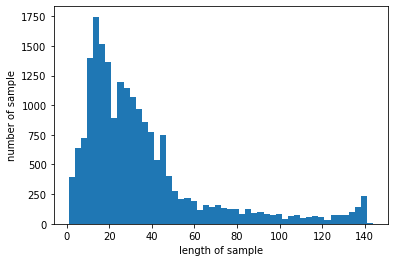

In [44]:
_, _, average_length = visualizing_length(input_data['document'].astype('str').tolist())

In [45]:
max_length_ip = int(round(average_length))
batch_size = 32
input_size = max_length_ip
num_layers = 2
embedding_dim = 64
hidden_size = 128
learning_rate = 1e-5
max_norm = 1 # gradient clipping
nb_epochs = 100

In [46]:
tokenized_ip, words_ip, num_vocab, label = vocab(input_data)
encoded_ip = integerEncoding(tokenized_ip, words_ip)

최대 길이 : 38
최소 길이 : 1
평균 길이 : 17.605709


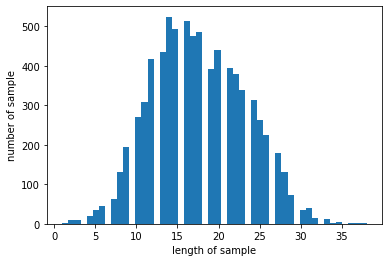

In [47]:
_, _, _ = visualizing_length([' '.join(lst) for lst in tokenized_ip])

In [48]:
padding(encoded_ip, words_ip, max_length_ip)

In [49]:
print("vocab length:", num_vocab)
print(tokenized_ip[:3])
print([' '.join(lst) for lst in tokenized_ip][:3])
print(label[:3])
print(encoded_ip[:3])

vocab length: 6899
[['구태의연하다', '끝', '을', '보다'], ['이', '영화', '왜', '출시', '안되다', 'ㅜㅠ'], ['정말', '소름끼치다', '다시', '방영', '해주다', '좋다']]
['구태의연하다 끝 을 보다', '이 영화 왜 출시 안되다 ㅜㅠ', '정말 소름끼치다 다시 방영 해주다 좋다']
['0', '1', '1']
[[6719, 4901, 1887, 4491, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [57, 818, 4637, 4376, 190, 609, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [6074, 38, 5556, 1726, 5851, 4475, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]


In [50]:
trn_input, trn_target, val_input, val_target = SplitData(encoded_ip, label)

In [51]:
trn_dataset, trn_dataset_size = MakeDataset(trn_input, trn_target)
trn_dataloader = MakeDataLoader(trn_dataset, batch_size)

val_dataset, val_dataset_size = MakeDataset(val_input, val_target)
val_dataloader = MakeDataLoader(val_dataset, batch_size)

In [52]:
print(checkdata(trn_dataloader))
print(checkdata(val_dataloader))

0 Batch
Input: torch.Size([32, 35])
Target: torch.Size([32, 1])
1 Batch
Input: torch.Size([32, 35])
Target: torch.Size([32, 1])
2 Batch
Input: torch.Size([32, 35])
Target: torch.Size([32, 1])
3 Batch
Input: torch.Size([32, 35])
Target: torch.Size([32, 1])
4 Batch
Input: torch.Size([32, 35])
Target: torch.Size([32, 1])
5 Batch
Input: torch.Size([32, 35])
Target: torch.Size([32, 1])
None
0 Batch
Input: torch.Size([32, 35])
Target: torch.Size([32, 1])
1 Batch
Input: torch.Size([32, 35])
Target: torch.Size([32, 1])
2 Batch
Input: torch.Size([32, 35])
Target: torch.Size([32, 1])
3 Batch
Input: torch.Size([32, 35])
Target: torch.Size([32, 1])
4 Batch
Input: torch.Size([32, 35])
Target: torch.Size([32, 1])
5 Batch
Input: torch.Size([32, 35])
Target: torch.Size([32, 1])
None


In [53]:
model = BILSTM(input_size, batch_size, hidden_size, num_layers, num_vocab, embedding_dim).to(device)
criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

In [54]:
print(model)
print(criterion)
print(optimizer)
print(checkfunction(trn_dataloader, epoch = 5))

BILSTM(
  (embedding): Embedding(6899, 64)
  (lstm): LSTM(35, 128, num_layers=2, dropout=0.3, bidirectional=True)
  (fc): Linear(in_features=256, out_features=128, bias=True)
)
CrossEntropyLoss()
Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 1e-05
    weight_decay: 0
)
0
torch.Size([1, 32, 35])
torch.Size([32, 128])
torch.Size([32])
tensor(4.8340, device='cuda:0', grad_fn=<NllLossBackward>)

1
torch.Size([1, 32, 35])
torch.Size([32, 128])
torch.Size([32])
tensor(4.8493, device='cuda:0', grad_fn=<NllLossBackward>)

2
torch.Size([1, 32, 35])
torch.Size([32, 128])
torch.Size([32])
tensor(4.8829, device='cuda:0', grad_fn=<NllLossBackward>)

3
torch.Size([1, 32, 35])
torch.Size([32, 128])
torch.Size([32])
tensor(4.8332, device='cuda:0', grad_fn=<NllLossBackward>)

4
torch.Size([1, 32, 35])
torch.Size([32, 128])
torch.Size([32])
tensor(4.8480, device='cuda:0', grad_fn=<NllLossBackward>)

5
torch.Size([1, 32, 35])
torch.Size([32, 128])
torch.Size([

In [55]:
trn_loss, val_loss = train(model, criterion, optimizer, nb_epochs, 
                           input_size, trn_dataloader, val_dataloader)

Epoch:   1 | Train Loss: 4.780750 | Val Loss: 4.703874
Epoch:   2 | Train Loss: 4.623768 | Val Loss: 4.533571
Epoch:   3 | Train Loss: 4.451238 | Val Loss: 4.339679
Epoch:   4 | Train Loss: 4.256584 | Val Loss: 4.133374
Epoch:   5 | Train Loss: 4.042545 | Val Loss: 3.895052
Epoch:   6 | Train Loss: 3.802809 | Val Loss: 3.638016
Epoch:   7 | Train Loss: 3.537462 | Val Loss: 3.343990
Epoch:   8 | Train Loss: 3.245475 | Val Loss: 3.034324
Epoch:   9 | Train Loss: 2.933924 | Val Loss: 2.705009
Epoch:  10 | Train Loss: 2.611085 | Val Loss: 2.363775
Epoch:  11 | Train Loss: 2.276235 | Val Loss: 2.036343
Epoch:  12 | Train Loss: 1.954357 | Val Loss: 1.727510
Epoch:  13 | Train Loss: 1.657402 | Val Loss: 1.450496
Epoch:  14 | Train Loss: 1.397068 | Val Loss: 1.234226
Epoch:  15 | Train Loss: 1.195589 | Val Loss: 1.066233
Epoch:  16 | Train Loss: 1.040915 | Val Loss: 0.949501
Epoch:  17 | Train Loss: 0.938320 | Val Loss: 0.868051
Epoch:  18 | Train Loss: 0.863638 | Val Loss: 0.816819
Epoch:  19

In [56]:
# 과적합 해결할것
# vocab json 파일로 저장해서 둘 것
# 자모 단위로 중복되는 문자열 제거